<a href="https://colab.research.google.com/github/AbrahamKong/CMPE297-Meta_Learning_and_Continuous_Learning/blob/main/CMPE297_Meta_Learning_and_Continuous_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# reptile MAML algorithm in keras/tensorflow for Meta Learning

### TensorFlow installation

In [1]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0

### Imports

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend


# Other dependencies
import random
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

# Reproduction
np.random.seed(333)


print('Python version: ', sys.version)
print('TensorFlow version: ', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

Python version:  3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]
TensorFlow version:  2.9.2
GPU found at: /device:GPU:0


## Evaluating MAML on regression

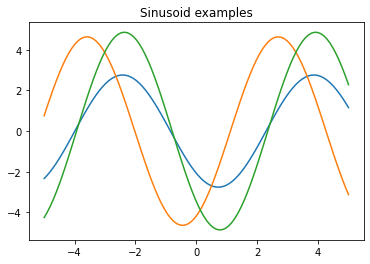

In [3]:
class SinusoidGenerator():
    '''
        Sinusoid Generator.
        
        p(T) is continuous, where the amplitude varies within [0.1, 5.0]
        and the phase varies within [0, π].
        
        This abstraction is the basically the same defined at:
        https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0  
    '''
    def __init__(self, K=10, amplitude=None, phase=None):
        '''
        Args:
            K: batch size. Number of values sampled at every batch.
            amplitude: Sine wave amplitude. If None is uniformly sampled from
                the [0.1, 5.0] interval.
            pahse: Sine wave phase. If None is uniformly sampled from the [0, π]
                interval.
        '''
        self.K = K
        self.amplitude = amplitude if amplitude else np.random.uniform(0.1, 5.0)
        self.phase = phase if amplitude else np.random.uniform(0, np.pi)
        self.sampled_points = None
        self.x = self._sample_x()
        
    def _sample_x(self):
        return np.random.uniform(-5, 5, self.K)
    
    def f(self, x):
        '''Sinewave function.'''
        return self.amplitude * np.sin(x - self.phase)

    def batch(self, x = None, force_new=False):
        '''Returns a batch of size K.
        
        It also changes the sape of `x` to add a batch dimension to it.
        
        Args:
            x: Batch data, if given `y` is generated based on this data.
                Usually it is None. If None `self.x` is used.
            force_new: Instead of using `x` argument the batch data is
                uniformly sampled.
        
        '''
        if x is None:
            if force_new:
                x = self._sample_x()
            else:
                x = self.x
        y = self.f(x)
        return x[:, None], y[:, None]
    
    def equally_spaced_samples(self, K=None):
        '''Returns `K` equally spaced samples.'''
        if K is None:
            K = self.K
        return self.batch(x=np.linspace(-5, 5, K))
        
        
def plot(data, *args, **kwargs):
    '''Plot helper.'''
    x, y = data
    return plt.plot(x, y, *args, **kwargs)


for _ in range(3):
    plt.title('Sinusoid examples')
    plot(SinusoidGenerator(K=100).equally_spaced_samples())
plt.show()

### Generate sinusoid datasets


In [4]:
def generate_dataset(K, train_size=20000, test_size=10):
    '''Generate train and test dataset.
    
    A dataset is composed of SinusoidGenerators that are able to provide
    a batch (`K`) elements at a time.
    '''
    def _generate_dataset(size):
        return [SinusoidGenerator(K=K) for _ in range(size)]
    return _generate_dataset(train_size), _generate_dataset(test_size) 

train_ds, test_ds = generate_dataset(K=10)

### Training a regular Neural Network

#### Model definition

In [5]:
class SineModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1)
        
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x

#### Training implementation

In [6]:
def loss_function(pred_y, y):
  return keras_backend.mean(keras.losses.mean_squared_error(y, pred_y))

def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)
    

def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model.forward(x)
    mse = loss_fn(y, logits)
    return mse, logits


def compute_gradients(model, x, y, loss_fn=loss_function):
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y, loss_fn)
    return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

    
def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss = compute_gradients(model, tensor_x, tensor_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return loss


def train_model(dataset, epochs=1, lr=0.001, log_steps=1000):
    model = SineModel()
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        losses = []
        total_loss = 0
        start = time.time()
        for i, sinusoid_generator in enumerate(dataset):
            x, y = sinusoid_generator.batch()
            loss = train_batch(x, y, model, optimizer)
            total_loss += loss
            curr_loss = total_loss / (i + 1.0)
            losses.append(curr_loss)
            
            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {:.2f} seconds'.format(
                    i, curr_loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.title('Loss Vs Time steps')
        plt.show()
    return model

#### Train Model

Step 1000: loss = 3.558862144681079, Time to run 1000 steps = 16.90 seconds
Step 2000: loss = 3.5200514989464535, Time to run 1000 steps = 6.87 seconds
Step 3000: loss = 3.399899038091944, Time to run 1000 steps = 6.88 seconds
Step 4000: loss = 3.317609740682783, Time to run 1000 steps = 6.84 seconds
Step 5000: loss = 3.286456345298084, Time to run 1000 steps = 7.13 seconds
Step 6000: loss = 3.2540636716301585, Time to run 1000 steps = 6.85 seconds
Step 7000: loss = 3.2201508298909878, Time to run 1000 steps = 6.89 seconds
Step 8000: loss = 3.1983504891764625, Time to run 1000 steps = 6.83 seconds
Step 9000: loss = 3.1704771694835476, Time to run 1000 steps = 6.91 seconds
Step 10000: loss = 3.1562372602115434, Time to run 1000 steps = 6.89 seconds
Step 11000: loss = 3.1548271788807356, Time to run 1000 steps = 6.81 seconds
Step 12000: loss = 3.1485066367752923, Time to run 1000 steps = 8.52 seconds
Step 13000: loss = 3.1473113239027937, Time to run 1000 steps = 6.92 seconds
Step 14000:

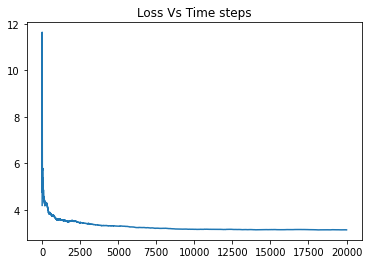

In [7]:
neural_net = train_model(train_ds)

In [8]:
def plot_model_comparison_to_average(model, ds, model_name='neural network', K=10):
    '''Compare model to average.
    
    Computes mean of training sine waves actual `y` and compare to
    the model's prediction to a new sine wave, the intuition is that
    these two plots should be similar.
    '''
    sinu_generator = SinusoidGenerator(K=K)
    
    # calculate average prediction
    avg_pred = []
    for i, sinusoid_generator in enumerate(ds):
        x, y = sinusoid_generator.equally_spaced_samples()
        avg_pred.append(y)
    
    x, _ = sinu_generator.equally_spaced_samples()    
    avg_plot, = plt.plot(x, np.mean(avg_pred, axis=0), '--')

    # calculate model prediction
    model_pred = model.forward(tf.convert_to_tensor(x))
    model_plot, = plt.plot(x, model_pred.numpy())
    
    # plot
    plt.legend([avg_plot, model_plot], ['Average', model_name])
    plt.show()

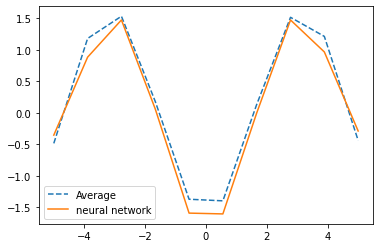

In [9]:
plot_model_comparison_to_average(neural_net, train_ds)

### Transfer learning

In [10]:
def copy_model(model, x):
    '''Copy model weights to a new model.
    
    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''
    copied_model = SineModel()
    
    # If we don't run this step the weights are not "initialized"
    # and the gradients will not be computed.
    copied_model.forward(tf.convert_to_tensor(x))
    
    copied_model.set_weights(model.get_weights())
    return copied_model


def eval_sine_test(model, optimizer, x, y, x_test, y_test, num_steps=(0, 1, 10)):
    '''Evaluate how the model fits to the curve training for `fits` steps.
    
    Args:
        model: Model evaluated.
        optimizer: Optimizer to be for training.
        x: Data used for training.
        y: Targets used for training.
        x_test: Data used for evaluation.
        y_test: Targets used for evaluation.
        num_steps: Number of steps to log.
    '''
    fit_res = []
    
    tensor_x_test, tensor_y_test = np_to_tensor((x_test, y_test))
    
    # If 0 in fits we log the loss before any training
    if 0 in num_steps:
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        fit_res.append((0, logits, loss))
        
    for step in range(1, np.max(num_steps) + 1):
        train_batch(x, y, model, optimizer)
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        if step in num_steps:
            fit_res.append(
                (
                    step, 
                    logits,
                    loss
                )
            )
    return fit_res


def eval_sinewave_for_test(model, sinusoid_generator=None, num_steps=(0, 1, 10), lr=0.01, plot=True):
    '''Evaluates how the sinewave addapts at dataset.
    
    The idea is to use the pretrained model as a weight initializer and
    try to fit the model on this new dataset.
    
    Args:
        model: Already trained model.
        sinusoid_generator: A sinusoidGenerator instance.
        num_steps: Number of training steps to be logged.
        lr: Learning rate used for training on the test data.
        plot: If plot is True than it plots how the curves are fitted along
            `num_steps`.
    
    Returns:
        The fit results. A list containing the loss, logits and step. For
        every step at `num_steps`.
    '''
    
    if sinusoid_generator is None:
        sinusoid_generator = SinusoidGenerator(K=10)
        
    # generate equally spaced samples for ploting
    x_test, y_test = sinusoid_generator.equally_spaced_samples(100)
    
    # batch used for training
    x, y = sinusoid_generator.batch()
    
    # copy model so we can use the same model multiple times
    copied_model = copy_model(model, x)
    
    # use SGD for this part of training as described in the paper
    optimizer = keras.optimizers.SGD(learning_rate=lr)
    
    # run training and log fit results
    fit_res = eval_sine_test(copied_model, optimizer, x, y, x_test, y_test, num_steps)
    
    # plot
    train, = plt.plot(x, y, '^')
    ground_truth, = plt.plot(x_test, y_test)
    plots = [train, ground_truth]
    legend = ['Training Points', 'True Function']
    for n, res, loss in fit_res:
        cur, = plt.plot(x_test, res[:, 0], '--')
        plots.append(cur)
        legend.append(f'After {n} Steps')
    plt.legend(plots, legend)
    plt.ylim(-5, 5)
    plt.xlim(-6, 6)
    if plot:
        plt.show()
    
    return fit_res

### Transfer learning for different sine waves for comparison

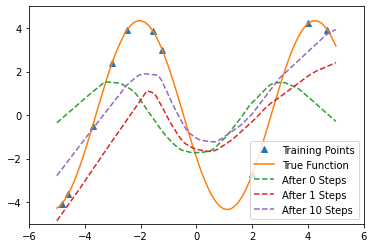

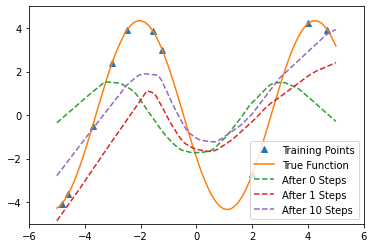

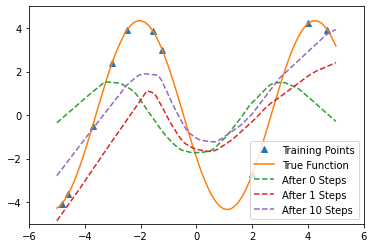

In [11]:
for index in np.random.randint(0, len(test_ds), size=3):
    eval_sinewave_for_test(neural_net, test_ds[index])

### MAML

In [12]:
def train_maml(model, epochs, dataset, lr_inner=0.01, batch_size=1, log_steps=1000):
    '''Train using the MAML setup.
    
    The comments in this function that start with:
        
        Step X:
        
    Refer to a step described in the Algorithm 1 of the paper.
    
    Args:
        model: A model.
        epochs: Number of epochs used for training.
        dataset: A dataset used for training.
        lr_inner: Inner learning rate (alpha in Algorithm 1). Default value is 0.01.
        batch_size: Batch size. Default value is 1. The paper does not specify
            which value they use.
        log_steps: At every `log_steps` a log message is printed.
    
    Returns:
        A strong, fully-developed and trained maml.
    '''
    optimizer = keras.optimizers.Adam()
    
    # Step 2: instead of checking for convergence, we train for a number
    # of epochs
    for _ in range(epochs):
        total_loss = 0
        losses = []
        start = time.time()
        # Step 3 and 4
        for i, t in enumerate(random.sample(dataset, len(dataset))):
            x, y = np_to_tensor(t.batch())
            model.forward(x)  # run forward pass to initialize weights
            with tf.GradientTape() as test_tape:
                # test_tape.watch(model.trainable_variables)
                # Step 5
                with tf.GradientTape() as train_tape:
                    train_loss, _ = compute_loss(model, x, y)
                # Step 6
                gradients = train_tape.gradient(train_loss, model.trainable_variables)
                k = 0
                model_copy = copy_model(model, x)
                for j in range(len(model_copy.layers)):
                    model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,
                                tf.multiply(lr_inner, gradients[k]))
                    model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,
                                tf.multiply(lr_inner, gradients[k+1]))
                    k += 2
                # Step 8
                test_loss, logits = compute_loss(model_copy, x, y)
            # Step 8
            gradients = test_tape.gradient(test_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            # Logs
            total_loss += test_loss
            loss = total_loss / (i+1.0)
            losses.append(loss)
            
            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {}'.format(i, loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.show()

#### Training MAML


Step 1000: loss = 2.6713578867257084, Time to run 1000 steps = 32.31967496871948
Step 2000: loss = 2.069548783753291, Time to run 1000 steps = 32.46477222442627
Step 3000: loss = 1.7481327526743018, Time to run 1000 steps = 32.22152066230774
Step 4000: loss = 1.5075637175205343, Time to run 1000 steps = 33.716033697128296
Step 5000: loss = 1.3400438206591965, Time to run 1000 steps = 32.5027961730957
Step 6000: loss = 1.2173248276593849, Time to run 1000 steps = 32.36322331428528
Step 7000: loss = 1.1229703945117453, Time to run 1000 steps = 32.27020025253296
Step 8000: loss = 1.0483734019512951, Time to run 1000 steps = 32.30623435974121
Step 9000: loss = 0.9871057501891832, Time to run 1000 steps = 32.59169149398804
Step 10000: loss = 0.9352559975348127, Time to run 1000 steps = 32.09026479721069
Step 11000: loss = 0.8900031046760697, Time to run 1000 steps = 32.04974412918091
Step 12000: loss = 0.851491755509269, Time to run 1000 steps = 33.41697287559509
Step 13000: loss = 0.817609

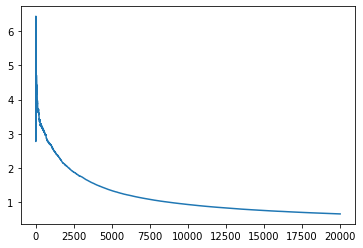

In [13]:
maml = SineModel()
train_maml(maml, 1, train_ds)

#### Use MAML model to fit new sine wave

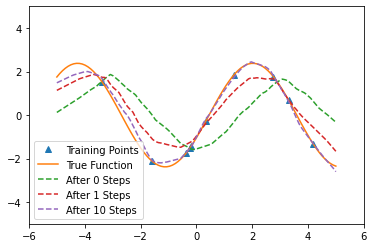

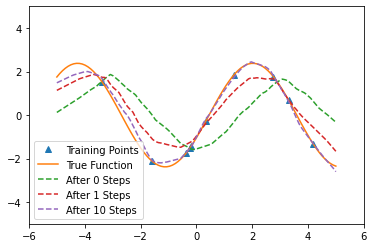

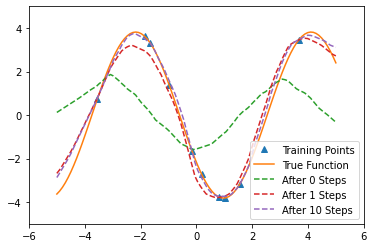

In [14]:
for index in np.random.randint(0, len(test_ds), size=3):
    eval_sinewave_for_test(maml, test_ds[index])

### MAML vs Regular Neural Network

In [15]:
def compare_maml_and_neural_net(maml, neural_net, sinusoid_generator, num_steps=list(range(10)),
                                intermediate_plot=True, marker='x', linestyle='--'):
    '''Compare the loss of a MAML model and a neural net.
    
    Fits the models for a new task (new sine wave) and then plot
    the loss of both models along `num_steps` interactions.
    
    Args:
        maml: An already trained MAML.
        neural_net: An already trained neural net.
        num_steps: Number of steps to be logged.
        intermediate_plot: If True plots intermediate plots from
            `eval_sinewave_for_test`.
        marker: Marker used for plotting.
        linestyle: Line style used for plotting.
    '''
    if intermediate_plot:
        print('MAML')
    fit_maml = eval_sinewave_for_test(maml, sinusoid_generator, plot=intermediate_plot)
    if intermediate_plot:
        print('Neural Net')
    fit_neural_net = eval_sinewave_for_test(neural_net, sinusoid_generator, plot=intermediate_plot)
    
    fit_res = {'MAML': fit_maml, 'Neural Net': fit_neural_net}
    
    legend = []
    for name in fit_res:
        x = []
        y = []
        for n, _, loss in fit_res[name]:
            x.append(n)
            y.append(loss)
        plt.plot(x, y, marker=marker, linestyle=linestyle)
        plt.xticks(num_steps)
        legend.append(name)
    plt.legend(legend)
    plt.show()

MAML


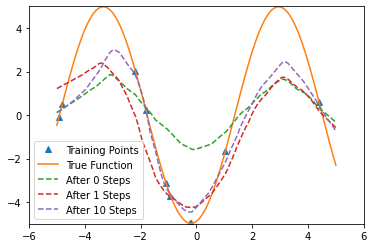

Neural Net


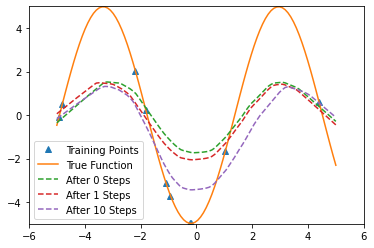

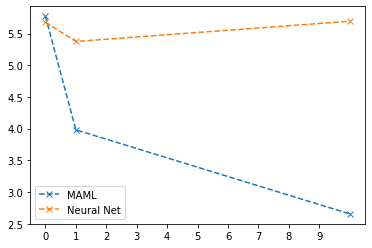

MAML


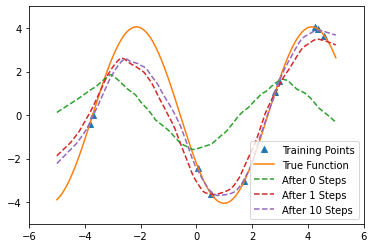

Neural Net


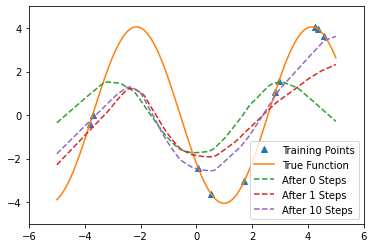

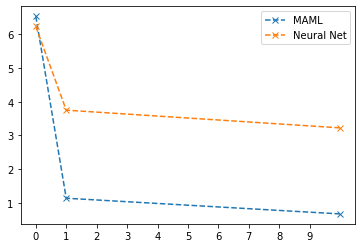

MAML


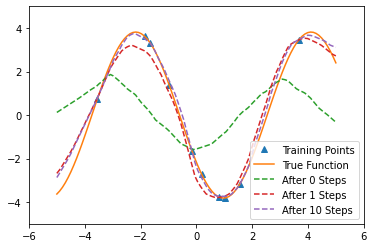

Neural Net


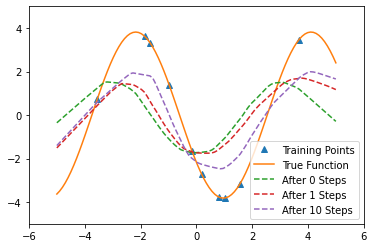

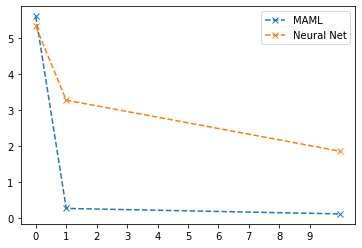

In [16]:
for _ in range(3):
    index = np.random.choice(range(len(test_ds)))
    compare_maml_and_neural_net(maml, neural_net, test_ds[index])

# Meta Learning using Prototypical Networks in Pytorch

## Discovering Prototypical Networks

In [2]:
!pip install easyfsl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 2.6 MB/s 


In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [4]:
image_size = 28

# NB: background=True selects the train set, background=False selects the test set
# It's the nomenclature from the original paper, we just have to deal with it

train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)


  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting ./data/omniglot-py/images_background.zip to ./data/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting ./data/omniglot-py/images_evaluation.zip to ./data/omniglot-py


In [5]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
N_WAY = 5 # Number of classes in a task
N_SHOT = 5 # Number of images per class in the support set
N_QUERY = 10 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [instance[1] for instance in test_set._flat_character_images]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


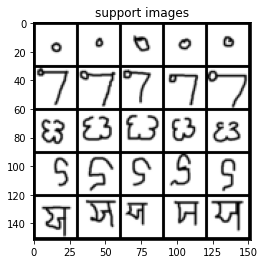

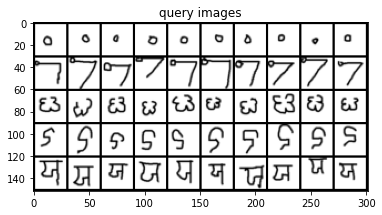

In [7]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)


In [8]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )


Ground Truth / Predicted
Manipuri/character22 / Manipuri/character22
Manipuri/character22 / Manipuri/character22
Manipuri/character22 / Manipuri/character22
Manipuri/character22 / Manipuri/character22
Manipuri/character22 / Manipuri/character22
Manipuri/character22 / Manipuri/character22
Manipuri/character22 / Manipuri/character22
Manipuri/character22 / Manipuri/character22
Manipuri/character22 / Manipuri/character22
Manipuri/character22 / Manipuri/character22
Angelic/character16 / Angelic/character16
Angelic/character16 / Angelic/character16
Angelic/character16 / Angelic/character16
Angelic/character16 / Angelic/character16
Angelic/character16 / Angelic/character16
Angelic/character16 / Angelic/character16
Angelic/character16 / Angelic/character16
Angelic/character16 / Angelic/character16
Angelic/character16 / Angelic/character16
Angelic/character16 / Angelic/character16
Kannada/character22 / Kannada/character22
Kannada/character22 / Mongolian/character09
Kannada/character22 / Kannada

In [9]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)


100%|██████████| 100/100 [00:06<00:00, 15.91it/s]

Model tested on 100 tasks. Accuracy: 86.20%


## Training a meta-learning algorithm

In [10]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

# train_set.labels = [instance[1] for instance in train_set._flat_character_images]   #incorrect, ignore this line; the following line is correct. 
train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()


In [ ]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))


 23%|██▎       | 9015/40000 [10:06<36:44, 14.05it/s, loss=0.467]

In [ ]:
# Or just load mine

!wget https://public-sicara.s3.eu-central-1.amazonaws.com/easy-fsl/resnet18_with_pretraining.tar
model.load_state_dict(torch.load("resnet18_with_pretraining.tar", map_location="cuda"))


In [ ]:
evaluate(test_loader)


# Meta Learning on BERT

In [ ]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

## Define Hyper *Parameter*

In [ ]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5

## Prepare Dataset

In [ ]:
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [28, 28])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset


import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)


## Visualize some examples from the dataset


In [ ]:
def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)


## Train the model


In [ ]:
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )


## Visualize Results


In [ ]:
# First, some preprocessing to smooth the training and testing arrays for display.
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

# Reference

1. [Few-Shot learning with Reptile](https://keras.io/examples/vision/reptile/)
2. [Tutorial 12: Meta-Learning - Learning to Learn](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/course_UvA-DL/12-meta-learning.ipynb)
3. [Fewshot text classification with meta learning and BERT](https://github.com/mailong25/meta-learning-bert)
3. [Few-Shot learning with Reptile](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/reptile.ipynb)
5. [Few Shot Learning with Code - Meta Learning - Prototypical Networks](https://www.youtube.com/watch?v=YkeE7oRxF24&ab_channel=Lights%2CCamera%2CVision%21)
6. [MAML reimplementation using TensorFlow 2.0](https://colab.research.google.com/github/mari-linhares/tensorflow-maml/blob/master/maml.ipynb)